## Plan

**Introduction:**
The target column in our dataset is for predicting whether the passenger survived or not. We will undertake several steps to discover the intrinsic relationships within the dataset.

**Strategy:**
Our interest in this project is to streamline the data transformation processes using pipelines and compositions. There will be two pipelines, one for categorical data and another for numerical data. In the end, we will combine the pipelines and apply grid search to our dataset.

**Outcome:**
At the end of the analysis, we expect to identify patterns in the catastrophe. However, in the end, it will likely be a random event because it involves a catastrophe. The difference is that we will probably observe a pattern.

#### Tools

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import statistics

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


from sklearn.ensemble import AdaBoostClassifier

### Settings

In [2]:
%matplotlib inline

sns.set_style('whitegrid')
sns.set_palette('crest')

plt.rcParams['figure.figsize'] = 12, 4

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
sample = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

#### Fuctions

In [4]:
## show categorical and numerical featues
def show_types(data):
    catvars = data.select_dtypes(include=['object']).columns
    numvars = data.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns
    print(f'Categorical: {catvars}\n')
    print(f'Numerical: {numvars}\n')
    
## plot nulls percentage    
def plot_null_percentage(data):
    percentage_null = np.round((data.isnull().sum() / len(data)) * 100, 2).sort_values(ascending=False)
    percentage_null_plot = percentage_null[percentage_null != 0]
    percentage_null_plot.plot(kind='barh')
    sns.despine(left=True)
    
## count categorical data
def count_cat(data):
    to_view = data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin']).to_list()
    for view in to_view:
        sns.countplot(x = data[view])
        plt.title(view)
        plt.show()

def show_density(data):
    to_view = data.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.to_list()
    for view in to_view:
        sns.kdeplot(x = data[view], fill=True)
        plt.title(view)
        plt.show()

def show_nulls(data):
    to_view = data.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.to_list()
    for view in to_view:
        sns.boxplot(x = data[view])
        plt.title(view)
        plt.show()

def detect_ouliters(data, column):
    anomalies = []
    df_std = statistics.stdev(data[column])
    df_mean = statistics.mean(data[column])
    
    anomaly_cut_off = df_std * 3
    
    lower_limit = df_mean - anomaly_cut_off
    upper_limit = df_mean + anomaly_cut_off
    
    for outlier in data[column]:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
        
    return anomalies

## Analyse

In [5]:
train ## all rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### General Characteristics

- Columns: 12
- Rows: 890
- Nulls: Present (We will analyze the proportion soon), in three out of twelve columns.

#### Nulos

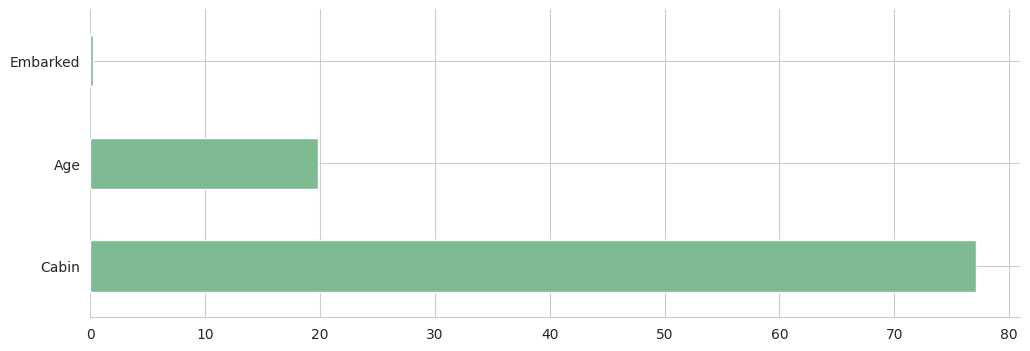

In [6]:
plot_null_percentage(train)

The *Cabin* and *Age* columns should be studied with caution. For now, we can consider two possibilities:

- Keep all columns and fill missing values with means or modes (for categorical columns)
- Eliminate the Cabin column

#### Data Types

As mentioned before, we have 12 columns distributed as follows:

#### Categorical
1. Name
2. Sex
3. Ticket
4. Cabin
5. Embarked
6. Survived

#### Numeric
7. PassengerId
8. Pclass
9. Age
10. SibSp
11. Parch
12. Fare

#### Explore 

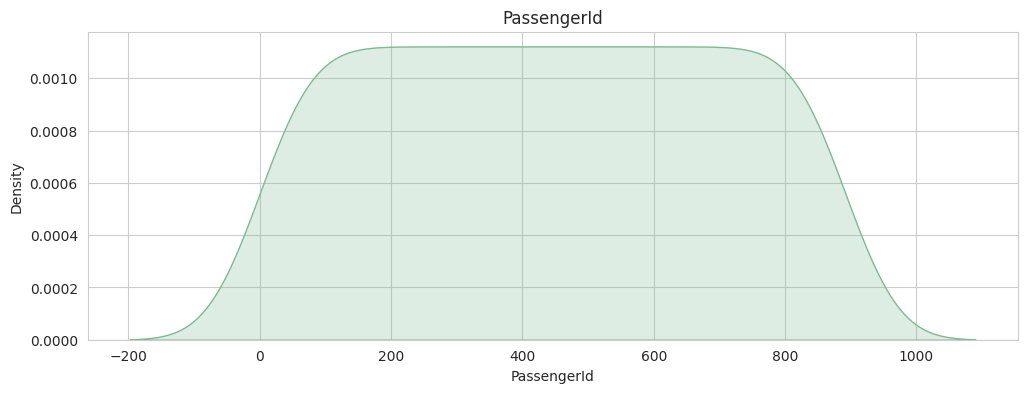

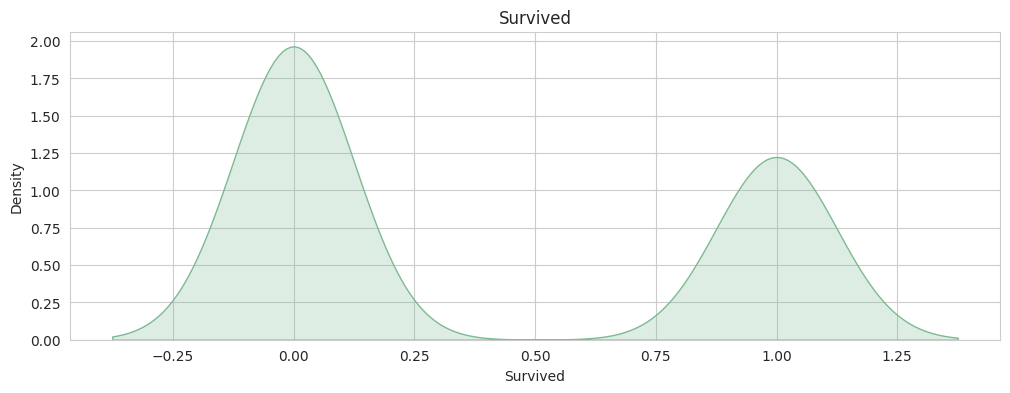

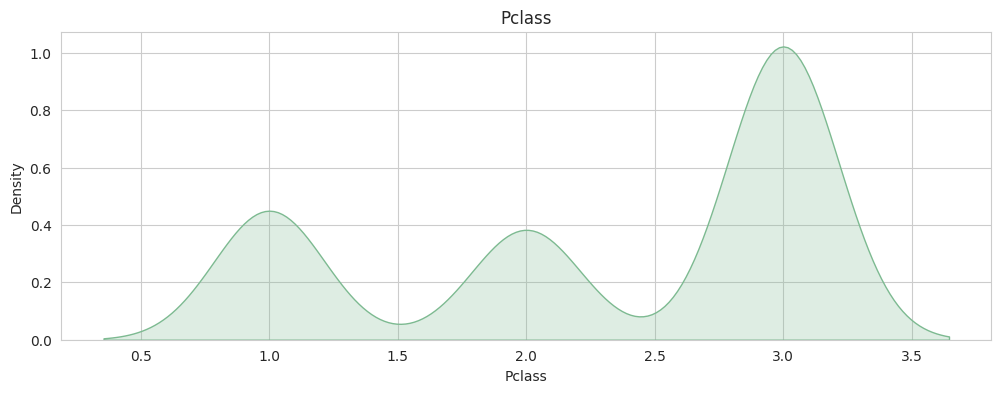

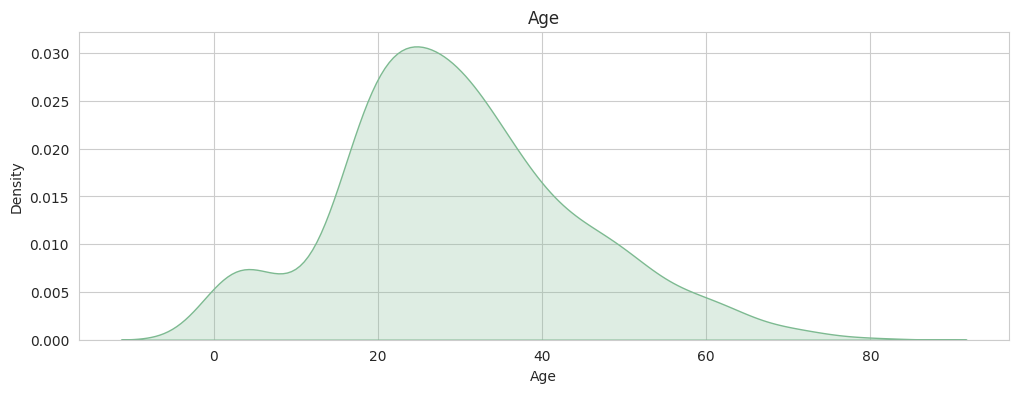

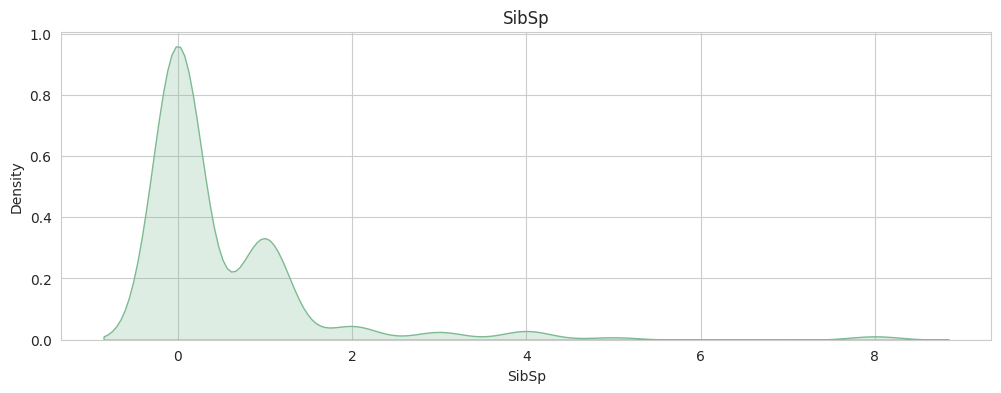

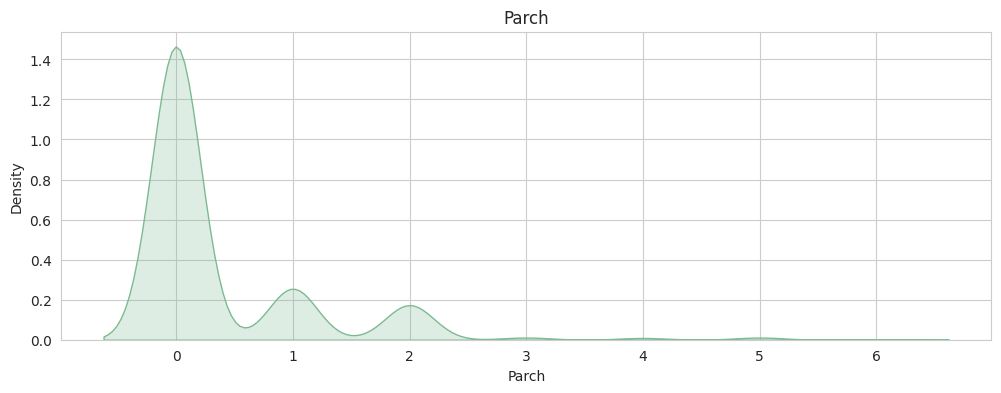

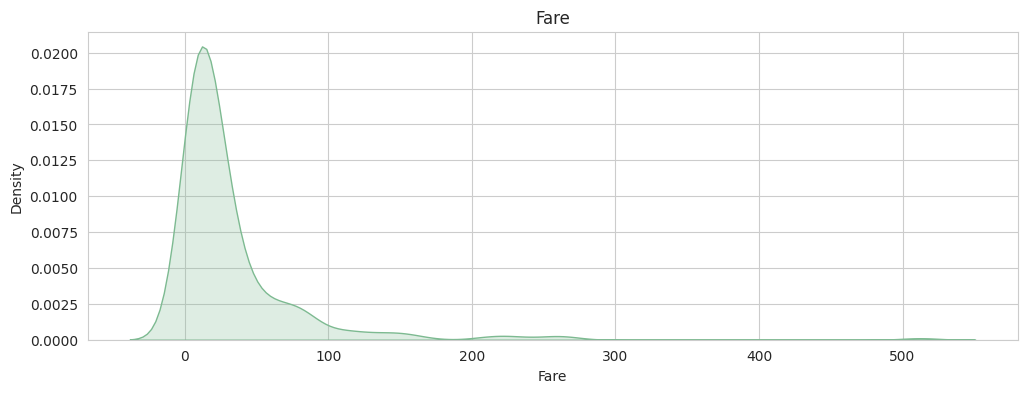

In [7]:
show_density(train)

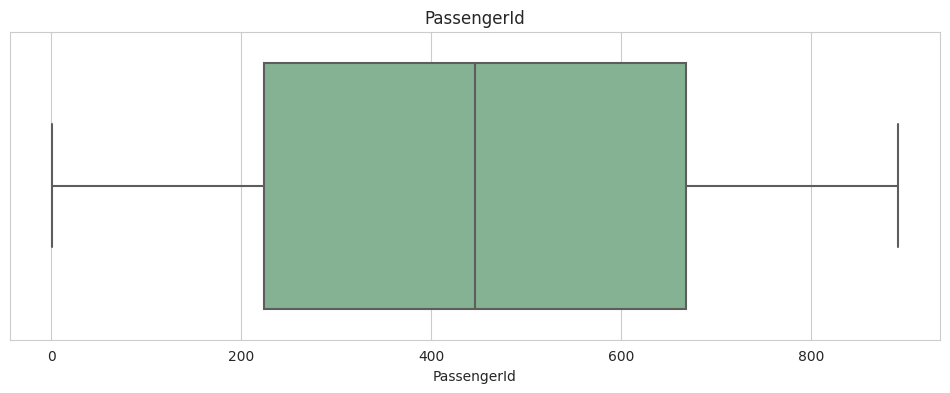

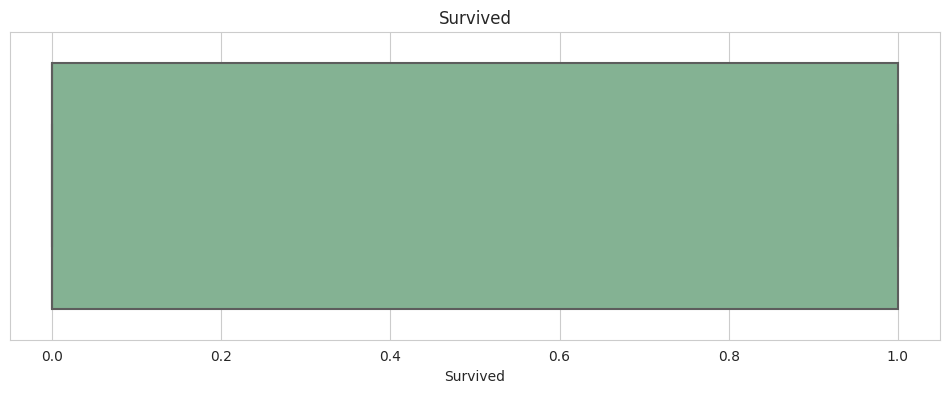

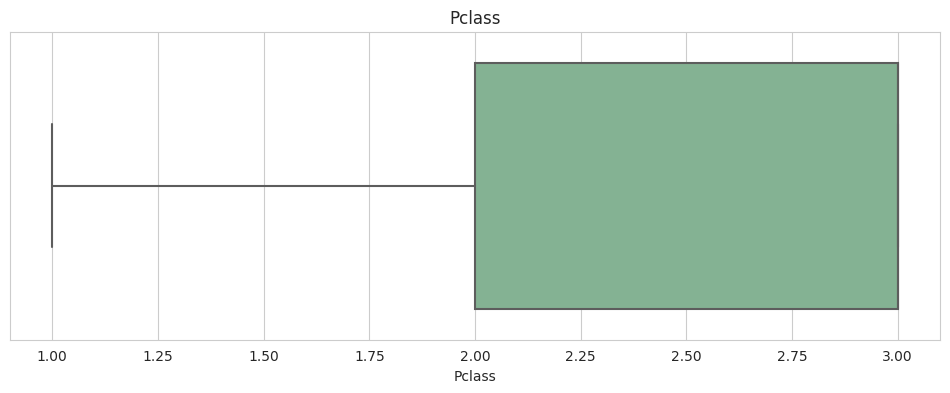

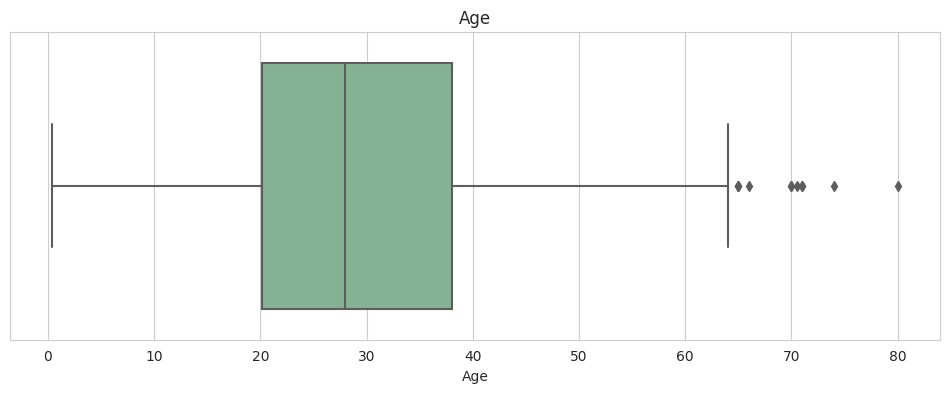

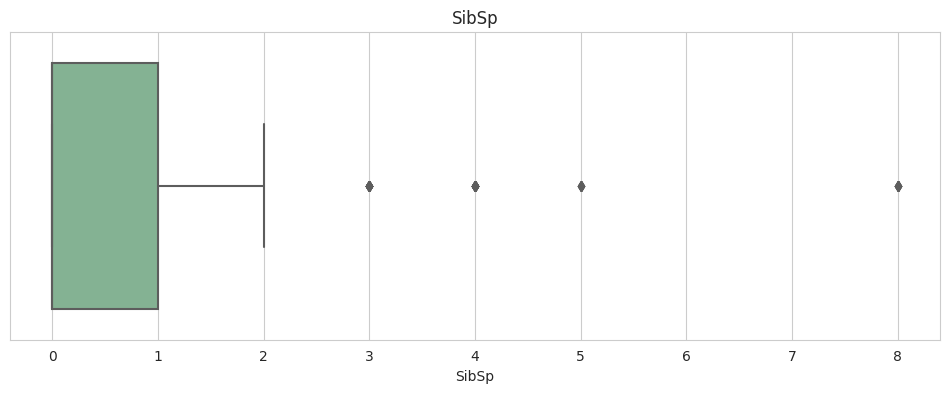

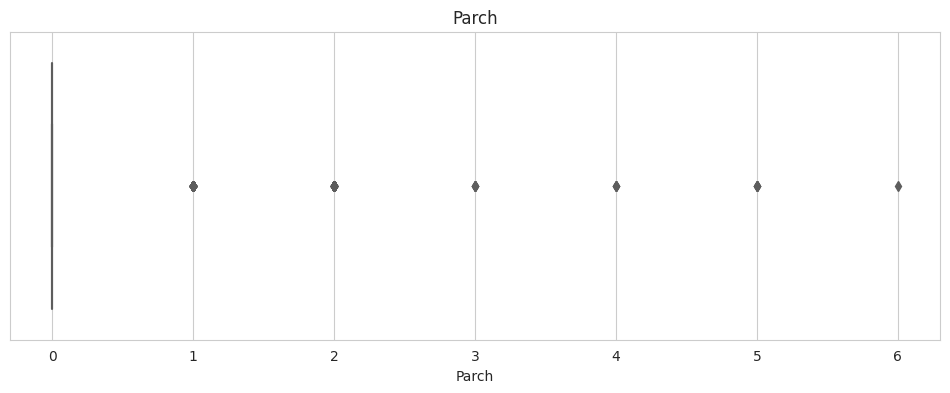

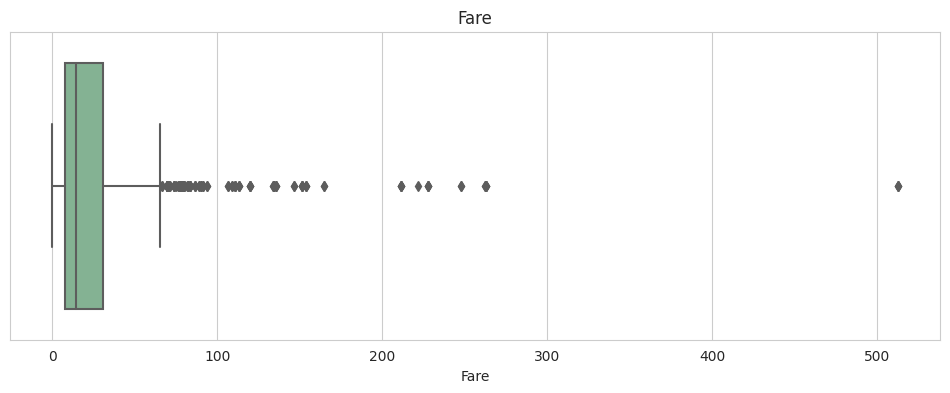

In [8]:
show_nulls(train)

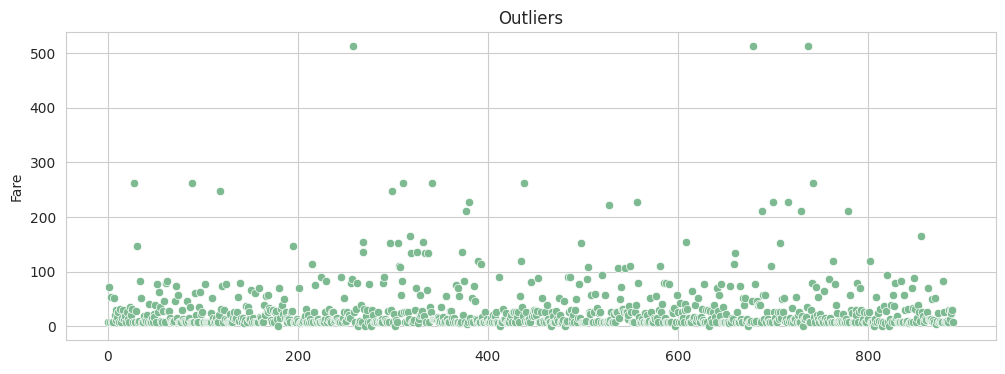

In [9]:
sns.scatterplot(train['Fare'])
plt.title("Outliers");

**Observations**: The Id column does not represent something truly relevant for the 'mathematics' of the problem. The Survived column (Target) is numeric but of categorical origin, indicating only whether someone survived or not. We will need to transform it.

#### Detect Ouliers

In [10]:
np.round(train.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.0,2.0,30.0,1.0,0.0,32.0
std,257.0,0.0,1.0,15.0,1.0,1.0,50.0
min,1.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,224.0,0.0,2.0,20.0,0.0,0.0,8.0
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.0
75%,668.0,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.0


In [11]:
## 3-SIGMA
outliers = pd.DataFrame(detect_ouliters(train, 'Fare'))
outliers.columns = ['Outliers']
np.round(outliers, 2).sort_values('Outliers', ascending=False)

,Outliers
3,512.33
12,512.33
17,512.33
0,263.00
6,263.00
9,263.00
1,263.00
5,262.38
18,262.38
2,247.52


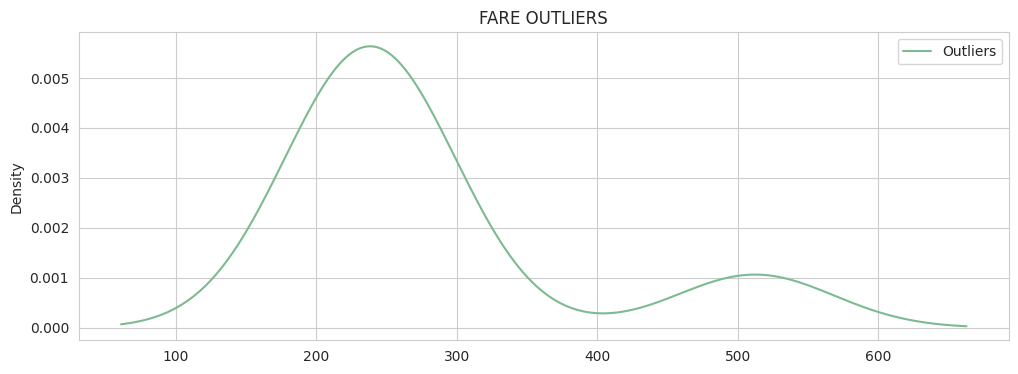

In [12]:
## 3-SIGMA
outliers = pd.DataFrame(detect_ouliters(train, 'Fare'))
outliers.columns = ['Outliers']
np.round(outliers, 2).sort_values('Outliers', ascending=False).plot(kind='kde')
plt.title("FARE OUTLIERS");

#### Processing data

- Scaling
- SimpleImput
- OneHotEncoder

In [13]:
numerical_pipeline = Pipeline(
    
    steps = [
        
            ('imputation_mean', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scale', QuantileTransformer(n_quantiles = 100))
    ]

)

categorical_pipeline = Pipeline(
    
    steps = [
        
        ('imputation_constant', SimpleImputer(fill_value = np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = "ignore"))
    ]

)

In [14]:
pre_processing = ColumnTransformer(
    
    transformers = [('numerical_pipeline', numerical_pipeline, ['Fare', 'Age', 'SibSp', 'Parch', 'Pclass']),
    ('categorical_pipeline', categorical_pipeline, ['Sex', 'Embarked'])]

)

In [15]:
final_pipe = make_pipeline(pre_processing, AdaBoostClassifier())
final_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   QuantileTransformer(n_quantiles=100))]),
                                                  ['Fare', 'Age', 'SibSp',
                                                   'Parch', 'Pclass']),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('adaboostclassifier', AdaBoostClassifier())])

#### Feature Importance

In [16]:
train_process = train.copy()

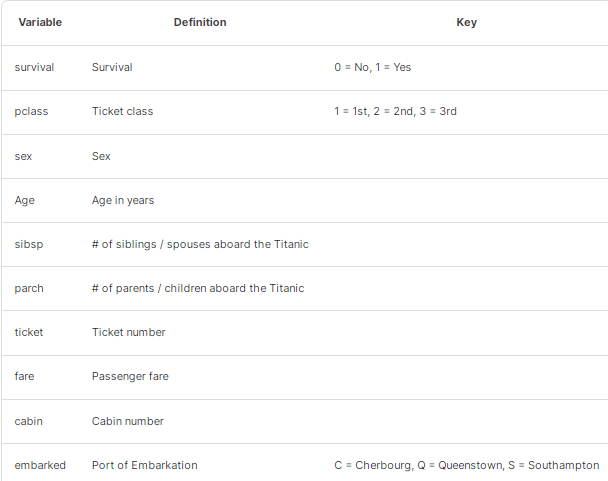

In [17]:
X = train_process.drop(['Survived', 'Name', 'Ticket'], axis = 1)
y = train_process['Survived']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [19]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   QuantileTransformer(n_quantiles=100))]),
                                                  ['Fare', 'Age', 'SibSp',
                                                   'Parch', 'Pclass']),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('adaboostclassifier', AdaBoostClassifier())])

In [20]:
ada_boost_classifier = final_pipe.named_steps['adaboostclassifier']
feature_importance = ada_boost_classifier.feature_importances_

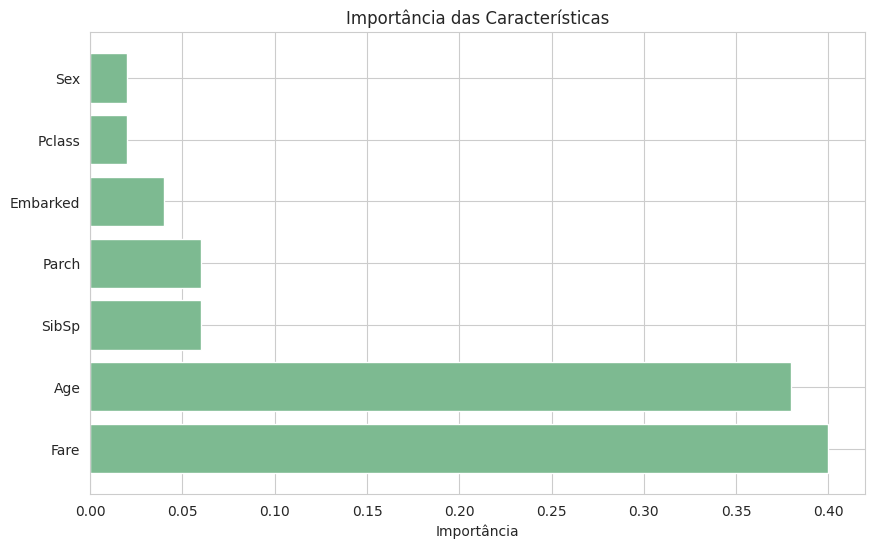

In [21]:
numerical_features = pre_processing.transformers_[0][2]
categorical_features = pre_processing.transformers_[1][2]
all_features = numerical_features + categorical_features
feature_importance_dict = dict(zip(all_features, feature_importance))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(list(sorted_feature_importance.keys()), sorted_feature_importance.values())
plt.xlabel('Importância')
plt.title('Importância das Características')
plt.show();

## ML

#### predictions

In [22]:
param_grid = {
    
    'adaboostclassifier__n_estimators': [50, 100, 200],
    'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5, 1.0]
}

In [23]:
grid_search = GridSearchCV(final_pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('imputation_mean',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          QuantileTransformer(n_quantiles=100))]),
                                                                         ['Fare',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Pclass']),
                                                                        ('categorical_pipeline',
                                                                         Pipeline(steps=[('imputation_constant',
                                                                                          SimpleImputer(fill_value=nan,
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier())]),
             param_grid={'adaboostclassifier__learning_rate': [0.01, 0.1, 0.5,
                                                               1.0],
                         'adaboostclassifier__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [24]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Acurácia no conjunto de teste:", grid_search.score(X_test, y_test))

Melhores parâmetros: {'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 200}
Acurácia no conjunto de teste: 0.8156424581005587


In [25]:
best_model = grid_search.best_estimator_

In [26]:
y_pred = best_model.predict(X_test)

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[89, 16],
       [17, 57]])